# Applying _sWeights_ to mitigate background

Sideband subtraction and fit-and-count are great, but they both have their downsides: sideband subtraction can only be used in a few clean cases; fit-and-count takes a while for large binning schemes and can have trouble converging. What if we could have our cake and eat it?

We can instead apply the [_sPlot_ method](https://arxiv.org/abs/physics/0402083) to determine per-event weights which can then be used to remove background. For this, we need to fit again, but only the the global distributions of each category, rather than bin-by-bin.

We start again with some imports:

In [1]:
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import ROOT as R
from triggercalib import HltEff
from triggercalib.utils.helpers import tgraph_to_np

hep.style.use("LHCb2")
R.EnableImplicitMT(8)

Welcome to JupyROOT 6.30/04


The configuration is the same as before as we can use the same observable and PDF here:

In [2]:
model_description = {
    "signal" : { # Name of component 
        "model" : "CrystalBall", # Name of PDF to be used
        "params" : { # Parameters to be used
            "mu" : [5279.4, 5275, 5285],
            "sigma" : [8.75, 6, 12],
            "alphal" : [1.4, 1.4, 1.4],
            "nl" : [7, 7, 7],
            "alphar" : [1.4, 1.4, 1.4],
            "nr" : [7, 7, 7],
        },
        "yield" : [10000, 0, 1000000] # Associated yield
    },
    "combinatorial" : {
        "model": "Exponential",
        "params" : {
            "exponent" : [-0.001, -0.01, -0.0001]
        },
        "yield": [1000, 0, 1000000]
    }
}

def build_roofit_pdf(ws, model_description):
    model_build_string = "SUM::pdf("
    for component_name, component_description in model_description.items():
        component_build_string = f"{component_description['model']}::{component_name}_pdf(B_DTF_Jpsi_MASS"
        for param_name, (param_val, param_min, param_max) in component_description['params'].items():
            component_build_string += f", {component_name}_{param_name}[{param_val}, {param_min}, {param_max}]"
        component_build_string += ")"
        print(f"Constructing '{component_name}_pdf' using description '{component_build_string}'")
        ws.factory(component_build_string)
        if "yield" in component_description:
            yield_val, yield_min, yield_max = component_description["yield"]
            model_build_string += f", {component_name}_yield[{yield_val}, {yield_min}, {yield_max}]*{component_name}_pdf"
    model_build_string += ")"
    
    print(f"Constructing 'pdf' using description '{model_build_string}'")
    pdf = ws.factory(model_build_string)
    return ws, pdf

ws = R.RooWorkspace("ws")
observable = ws.factory("B_DTF_Jpsi_MASS[5200, 5500]")
ws, pdf = build_roofit_pdf(ws, model_description)

Constructing 'signal_pdf' using description 'CrystalBall::signal_pdf(B_DTF_Jpsi_MASS, signal_mu[5279.4, 5275, 5285], signal_sigma[8.75, 6, 12], signal_alphal[1.4, 1.4, 1.4], signal_nl[7, 7, 7], signal_alphar[1.4, 1.4, 1.4], signal_nr[7, 7, 7])'
Constructing 'combinatorial_pdf' using description 'Exponential::combinatorial_pdf(B_DTF_Jpsi_MASS, combinatorial_exponent[-0.001, -0.01, -0.0001])'
Constructing 'pdf' using description 'SUM::pdf(, signal_yield[10000, 0, 1000000]*signal_pdf, combinatorial_yield[1000, 0, 1000000]*combinatorial_pdf)'


We can configure HltEff much the same as in the fit-and-count tutorial, only that this time we need to specify `sweights`, which will take as a value the name of the yield of our component of interest, here `signal_yield`. We can also ramp up the binning scheme again since we won't need to perform fits in each bin as before:

Fit performed with RooFit from ROOT 6.30/04

Initial parameters:
combinatorial_exponent: -0.001 +/- 0.0
combinatorial_yield: 1000.0 +/- 0.0
signal_alphal: 1.4 +/- 0.0
signal_alphar: 1.4 +/- 0.0
signal_mu: 5279.4 +/- 0.0
signal_nl: 7.0 +/- 0.0
signal_nr: 7.0 +/- 0.0
signal_sigma: 8.75 +/- 0.0
signal_yield: 10000.0 +/- 0.0

Final parameters:
combinatorial_exponent: -0.0019919954378112992 +/- 0.00012431460337454015
combinatorial_yield: 11777.41330996984 +/- 140.4892030150204
signal_alphal: 1.4 +/- 0.0
signal_alphar: 1.4 +/- 0.0
signal_mu: 5279.59863863204 +/- 0.04382781240201439
signal_nl: 7.0 +/- 0.0
signal_nr: 7.0 +/- 0.0
signal_sigma: 8.849793128825226 +/- 0.039710898775308756
signal_yield: 61327.05004362774 +/- 263.22125759115806

Covariance quality: 3
Fit status: 0
Minimum value: -422622.4951147965

Fit performed with RooFit from ROOT 6.30/04

Initial parameters:
combinatorial_exponent: -0.001 +/- 0.0
combinatorial_yield: 1000.0 +/- 0.0
signal_alphal: 1.4 +/- 0.0
signal_alphar: 1.4 +

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =      -345126.8492 Edm =       54410.96487 NCalls =     21
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : -345126.8492
  Edm           : 54410.96487
  Internal parameters:	[     0.9582415885     -1.507540228    -0.1202898824   -0.08343008661     -1.370461484]	
  Internal gradient  :	[     -121.4685862     -277979.8916     -474.6758704      -1401.67914      -530450.507]	
  Internal covariance matrix:
[[   0.0030352835              0              0              0              0]
 [              0  6.7547956e-07              0              0              0]
 [              0              0  0.00014845902              0              0]
 [              0              0              0  0.00027765213              0]
 [              0              0              0              0  5.8577452e-07]]]
Info in <Minuit2>: VariableMetricBuild

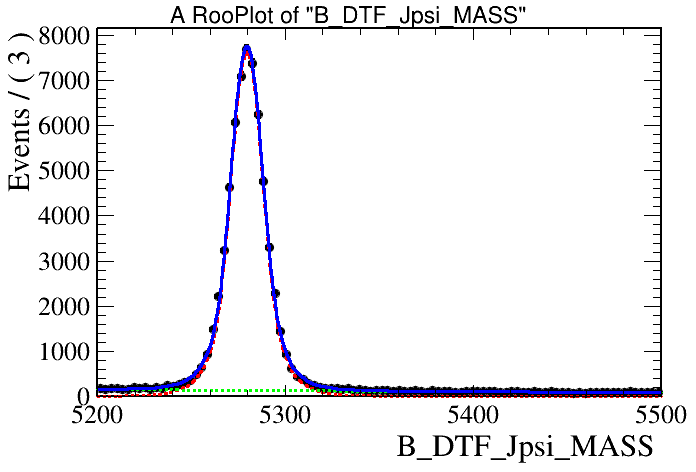

In [3]:
binning = {
    "B_PT" : {
        "bins" : [
            2e3,  3e3,  4e3,  5e3,
            6e3,  7e3,  8e3,  9e3,
            10e3, 11e3, 12e3, 13e3,
            14e3, 15e3, 16e3, 17e3,
            18e3, 19e3, 20e3, 21e3,
            22e3, 25e3
        ]
    }
}

hlt_eff = HltEff(
    "simple_example",
    "root://eoslhcb.cern.ch//eos/lhcb/wg/rta/WP4/TriggerCalib/Bu2JpsiK_Jpsi2MuMu_block1_ntuple.root:Tuple/DecayTree",
    tos="Hlt1TrackMVA",
    tis=["Hlt1TrackMVA", "Hlt1TwoTrackMVA"],
    particle="B", 
    binning=binning,
    observable=observable,
    pdf=pdf,
    fit_kwargs={
        "NumCPU" : 8,
    },
    output_path="sweights/",
    plots=True,
    trig_effs=False, # Avoids running fit for 'trig' category (only interested in TOS and TISTOS here)
    sweights="signal_yield"
)

There we have it, efficiencies ready to plot:

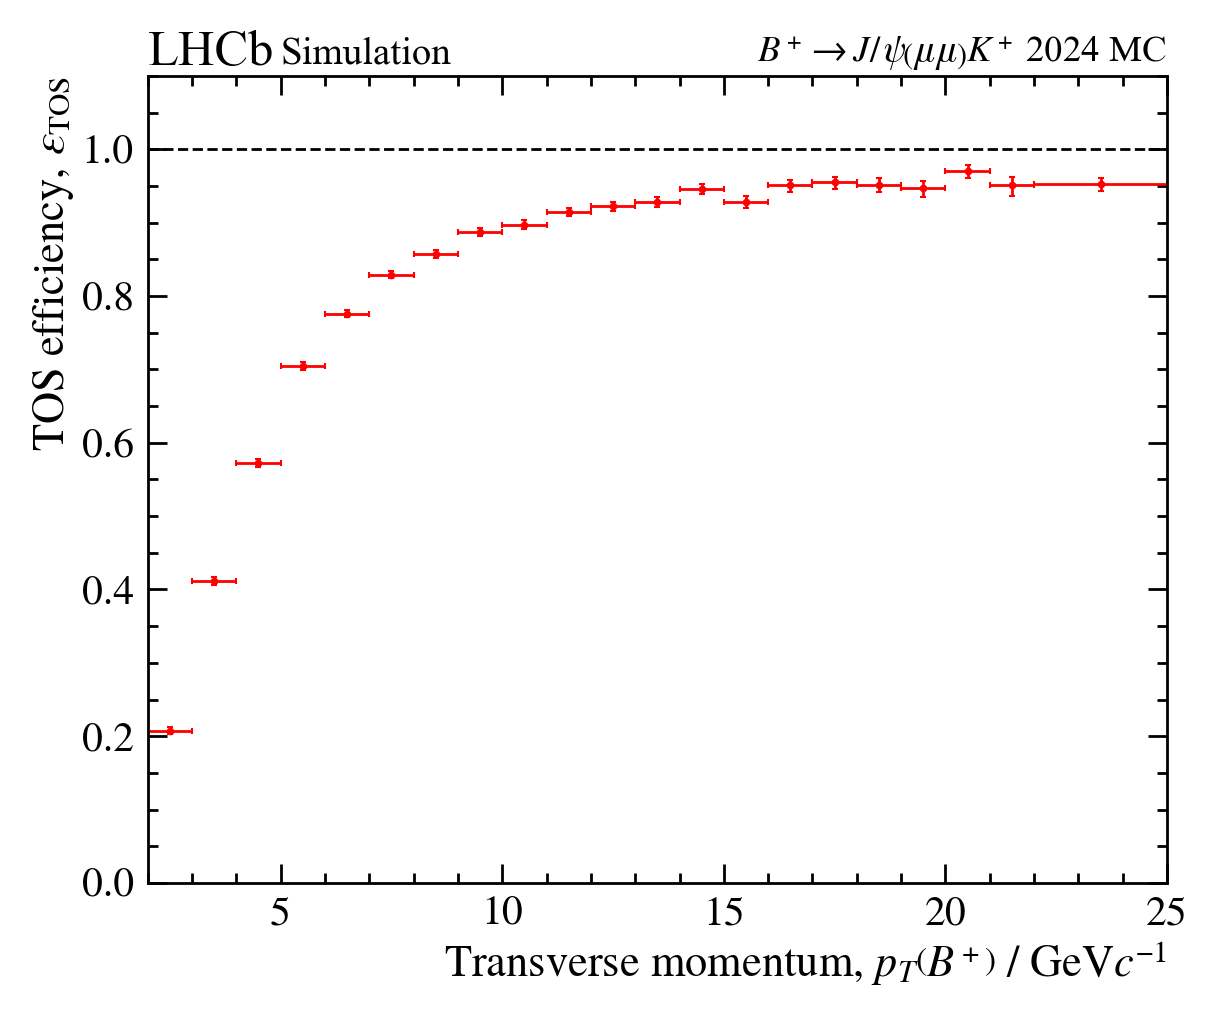

In [4]:
hist = hlt_eff.get_eff("tos_efficiency_B_PT")
midpoints, values, xerrors, yerrors = tgraph_to_np(hist, xscale=1e-3)
xmin = midpoints[0] - xerrors[0][0]
xmax = midpoints[-1] + xerrors[1][-1]

# Plot the efficiency #
plt.figure(figsize=(12,10))
plt.gca()

plt.plot((xmin, xmax), (1,1), color='k', ls='dashed', lw=2)
plt.errorbar(
    x=midpoints, y=values, xerr=xerrors, yerr=yerrors,
    color='r', elinewidth=2, ls="none", marker='.', markersize=8, 
)

plt.xlim(xmin, xmax)
plt.xlabel(r"Transverse momentum, $p_T\left(B^+\right)$ / $\mathrm{GeV}c^{-1}$")

plt.ylim(0, 1.1)
plt.ylabel(r"TOS efficiency, $\varepsilon_\mathrm{TOS}$")

hep.lhcb.label(loc=0, rlabel=r"$B^+\to J/\psi\left(\mu\mu\right)K^+$ 2024 MC")

plt.savefig("tos_efficiencies.pdf")
plt.show()

Now you might be thinking, _what's the catch?_ Well this method only works if your discriminant variable (the variable of the fit) and control variable(s) (the variable(s) of the histogram) are independent.